# SNR (Singnal to Noise Ratio) Analysis
The purpose of this notebook is to explore the importance of SNR deffinition in order to determine how much effort to put in to try to balance out the differences between LSNR and HSNR. it is possible that the SNR status of a spectogram holds useful information as different confidence margin or different succeptability to noise. <br>
the goal of this notebook is 3-fold:<br><br>
1. run our baseline model using the original data that has been used before the determine the baselinr measurments.<br>
2. preform errors exploration seperately for HSNR and LSNR images to determine wheather or not the SNR classification is significant for correct model output.<br>
3. If and only if step no.w will be found significant, We'll try to preform a more consice explorartion of the differences between HSNR and LSNR to see if we can find a continues measurment that describe the SNR. 

## Initializations


In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
reload(utils)

<module 'experiment_utils' from 'c:\\SOTA\\Mafat\\git\\code\\utils\\experiment_utils.py'>

In [3]:
import configparser
import os.path
from os import path

WANDB_enable = False
creds_path_ar = ["../credentials.ini","credentials.colab.ini"]
root_path = ""
data_path = ""

for creds_path in creds_path_ar:
  if path.exists(creds_path):
      config_parser = configparser.ConfigParser()
      config_parser.read(creds_path)
      root_path = config_parser['MAIN']["PATH_ROOT"]
      data_path = config_parser['MAIN']["PATH_DATA"]
      WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
      ENV = config_parser['MAIN']["ENV"]
      break


In [5]:
if root_path is not '':
  pass
elif os.path.isfile('path'):
  root_path = open('path', 'r').read()
else:
  root_path = input()
  path_file = open("path", "w")
  path_file.write(root_path)
  path_file.close()

In [10]:
cd git

c:\SOTA\Mafat\git


In [84]:
import os
import sys
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from importlib import reload  #use 'reload' to reload module manually if it was changed

from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

sys.path.insert(0,os.path.join(os.getcwd(),"code\\utils"))
import experiment_utils as utils


# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__


'2.3.0'

In [12]:
WANDB_enable = False

if WANDB_enable:
  !wandb login {utils.config_parser['DEFAULT']["WANDB_LOGIN"]}
  import wandb
  from wandb.keras import WandbCallback

In [14]:
# Set and test path to competition data files

if data_path is '':
  data_path = os.path.join(os.getcwd(),"data") 

try:
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{data_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set data_path correctly',
                color='red'))

Everything is setup correctly


In [16]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = utils.load_data(experiment_auxiliary, folder=data_path )
experiment_auxiliary_df['date_index'].shape

(49071,)

In [17]:
# Taking sample from the Auxiliary Experiment set
train_aux = utils.aux_split(experiment_auxiliary_df)
train_aux['date_index'].shape

(221,)

In [18]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [19]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = utils.load_data(train_path, folder=data_path )
print(f"real dataset({training_df['date_index'].shape})",end='')

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)
print(f" + aux dataset({train_aux['date_index'].shape}) = full train({train_df['date_index'].shape})")

# Preprocessing and split the data to training and validation
train_df = utils.data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y, is_validation_ar = utils.split_train_val(train_df)

train_df_t = train_df.copy()
del train_df_t['doppler_burst']
del train_df_t['iq_sweep_burst']
train_dff = pd.DataFrame(train_df_t)
train_dff['is_validation']=is_validation_ar

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
train_x = train_x.reshape(list(train_x.shape)+[1])
val_x = val_x.reshape(list(val_x.shape)+[1])

print(f"train only:{train_x.shape[0]}).  val only:{val_x.shape[0]}")


real dataset((6656,)) + aux dataset((221,)) = full train((6877,))
train only:6568).  val only:309


In [20]:
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = utils.load_data(test_path, folder=data_path )
test_df = utils.data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape)+[1])

In [21]:
train_dff.head(20)
#train_dff.to_csv("train_dff.csv", sep='\t')

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,is_validation
0,0,11,C,1,1,HighSNR,27,0,True
1,1,16,C,1,1,HighSNR,27,0,False
2,2,16,C,1,1,HighSNR,27,0,False
3,3,29,C,1,1,HighSNR,27,0,False
4,4,29,C,1,1,HighSNR,27,0,False
5,5,29,C,1,1,HighSNR,27,0,False
6,6,29,C,1,1,HighSNR,27,0,True
7,7,29,C,1,1,HighSNR,27,0,False
8,8,29,C,1,1,HighSNR,27,0,False
9,9,29,C,1,1,HighSNR,27,0,False


# Baseline CNN Model


In [15]:
# Building the model
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

In [22]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 10
optimizer = Adam(learning_rate = 0.001)
input_shape = (img_width, img_height, 1)

init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 30, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 6, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               737408    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4

In [24]:
# Model fit


callbacks = []
if WANDB_enable:
  wandb.init(project="mafat",name="first")
  callbacks.append(WandbCallback())

history = model.fit(train_x, train_y, batch_size = batch_size, epochs = no_epochs, 
                    validation_data = (val_x, val_y), callbacks=callbacks)

Epoch 1/10
411/411 [==============================] - 17s 42ms/step - loss: 0.4967 - auc: 0.9301 - accuracy: 0.9045 - val_loss: 0.5915 - val_auc: 0.8121 - val_accuracy: 0.7379
Epoch 2/10
411/411 [==============================] - 18s 43ms/step - loss: 0.2347 - auc: 0.9514 - accuracy: 0.9219 - val_loss: 0.5328 - val_auc: 0.8680 - val_accuracy: 0.7573
Epoch 3/10
411/411 [==============================] - 17s 41ms/step - loss: 0.2055 - auc: 0.9629 - accuracy: 0.9338 - val_loss: 0.4660 - val_auc: 0.8981 - val_accuracy: 0.7994
Epoch 4/10
411/411 [==============================] - 16s 39ms/step - loss: 0.1827 - auc: 0.9703 - accuracy: 0.9411 - val_loss: 0.5192 - val_auc: 0.9026 - val_accuracy: 0.7994
Epoch 5/10
411/411 [==============================] - 17s 41ms/step - loss: 0.1689 - auc: 0.9754 - accuracy: 0.9460 - val_loss: 0.4227 - val_auc: 0.9116 - val_accuracy: 0.8220
Epoch 6/10
411/411 [==============================] - 16s 39ms/step - loss: 0.1613 - auc: 0.9763 - accuracy: 0.9505 - va

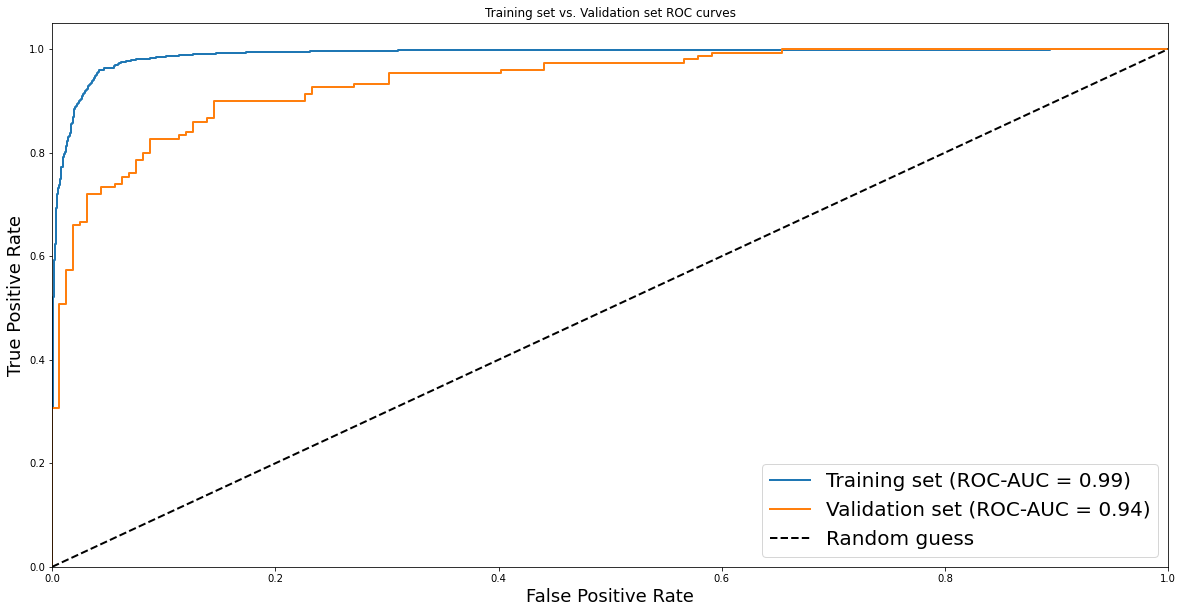

In [25]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
utils.stats(pred, actual)

Confusion matrix, without normalization
[[139  20]
 [ 22 128]]


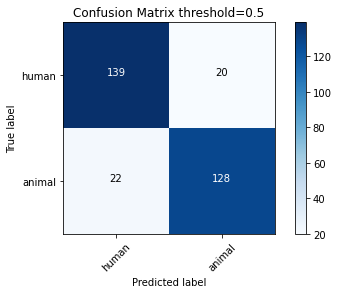

In [27]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

cm = confusion_matrix(y_true=val_y, y_pred=(model.predict(val_x)>0.5)*1)
cm_plot_labels = ['human','animal']

utils.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f"Confusion Matrix threshold={threshold}")

In [28]:
pred_val = (model.predict(val_x).flatten()>0.5)*1
df_idx = list(train_dff[train_dff.is_validation].index)
results_val = pd.DataFrame({'true':val_y, 'pred':pred_val,'df_idx':df_idx})


In [29]:
results_val.head()

,true,pred,df_idx
0,0,0,0
1,0,0,6
2,0,0,12
3,0,0,18
4,0,0,24


# Exploring results on LSNR vs. HSNR
at this stage we will check to see wheather the SNR level has significant impact on the confusion matrix of the model.<br>
first, we will seperate both the metadata dataset and the spectograms into 4 datasets (HSNR train and val and LSNR train and val)

In [35]:
train_dff.head()

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type,is_validation
0,0,11,C,1,1,HighSNR,27,0,True
1,1,16,C,1,1,HighSNR,27,0,False
2,2,16,C,1,1,HighSNR,27,0,False
3,3,29,C,1,1,HighSNR,27,0,False
4,4,29,C,1,1,HighSNR,27,0,False


In [59]:
train_dff_hsnr = train_dff[train_dff.snr_type=='HighSNR']
val_dff_hsnr = train_dff_hsnr[train_dff_hsnr.is_validation]
train_dff_hsnr = train_dff_hsnr[train_dff_hsnr.is_validation == False]
train_x_hsnr = train_x[train_dff[train_dff.is_validation==False].snr_type=='HighSNR']
val_x_hsnr = val_x[train_dff[train_dff.is_validation==True].snr_type=='HighSNR']
train_y_hsnr = train_y[train_dff[train_dff.is_validation==False].snr_type=='HighSNR']
val_y_hsnr = val_y[train_dff[train_dff.is_validation==True].snr_type=='HighSNR']

train_dff_lsnr = train_dff[train_dff.snr_type=='LowSNR']
val_dff_lsnr = train_dff_lsnr[train_dff_lsnr.is_validation]
train_dff_lsnr = train_dff_lsnr[train_dff_lsnr.is_validation == False]
train_x_lsnr = train_x[train_dff[train_dff.is_validation==False].snr_type=='LowSNR']
val_x_lsnr = val_x[train_dff[train_dff.is_validation==True].snr_type=='LowSNR']
train_y_lsnr = train_y[train_dff[train_dff.is_validation==False].snr_type=='LowSNR']
val_y_lsnr = val_y[train_dff[train_dff.is_validation==True].snr_type=='LowSNR']



In [48]:
print(f"Size of HSNR train set: {len(train_dff_hsnr)}, validation set:{len(val_dff_hsnr)}\nSize of LSNR train set: {len(train_dff_lsnr)}, validation set:{len(val_dff_lsnr)}" )

Size of HSNR train set: 2460, validation set:206
Size of LSNR train set: 4108, validation set:103


In [49]:
train_dff.snr_type.value_counts()

LowSNR     4211
HighSNR    2666
Name: snr_type, dtype: int64

**Note**: The train and validation sets are impbalnaced. there is twice as many LSNR samples in train, but twice as many HSNR samples in validation. also worth noting that the validation sets are pretty small, so a different test validation division might be worthwhile.

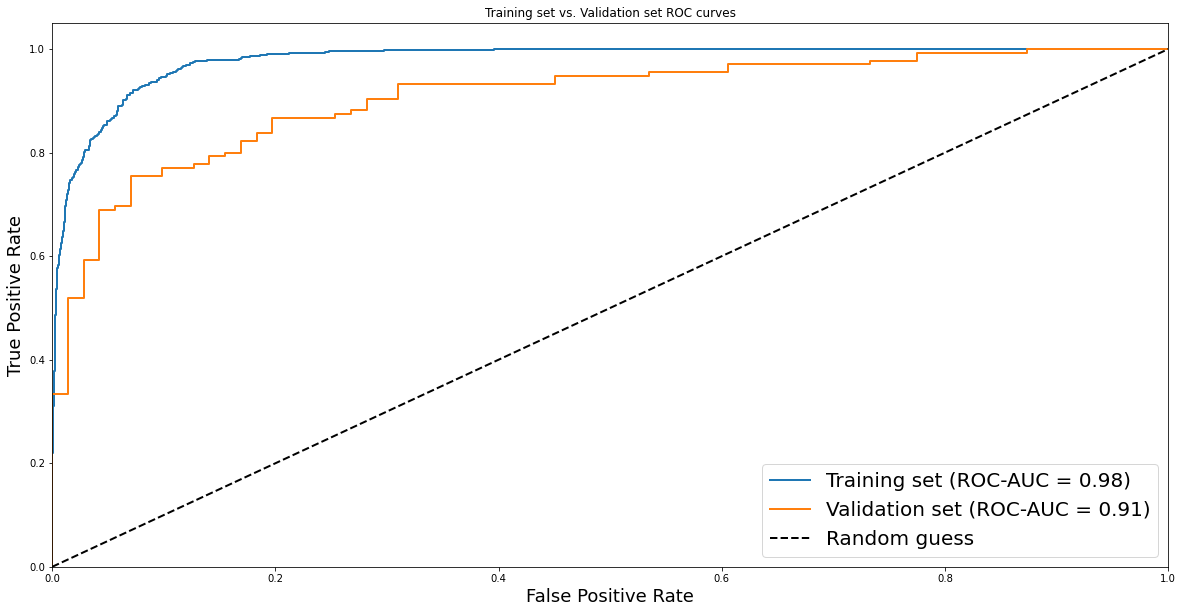

Confusion matrix, without normalization
[[ 51  20]
 [ 14 121]]


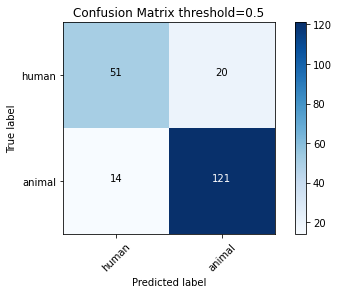

In [62]:
# HSNR
pred_hsnr = [model.predict(train_x_hsnr), model.predict(val_x_hsnr)]
actual_hsnr = [train_y_hsnr, val_y_hsnr]
utils.stats(pred_hsnr, actual_hsnr)

cm = confusion_matrix(y_true=val_y_hsnr, y_pred=( model.predict(val_x_hsnr)>0.5)*1)
cm_plot_labels = ['human','animal']

utils.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f"Confusion Matrix threshold={threshold}")

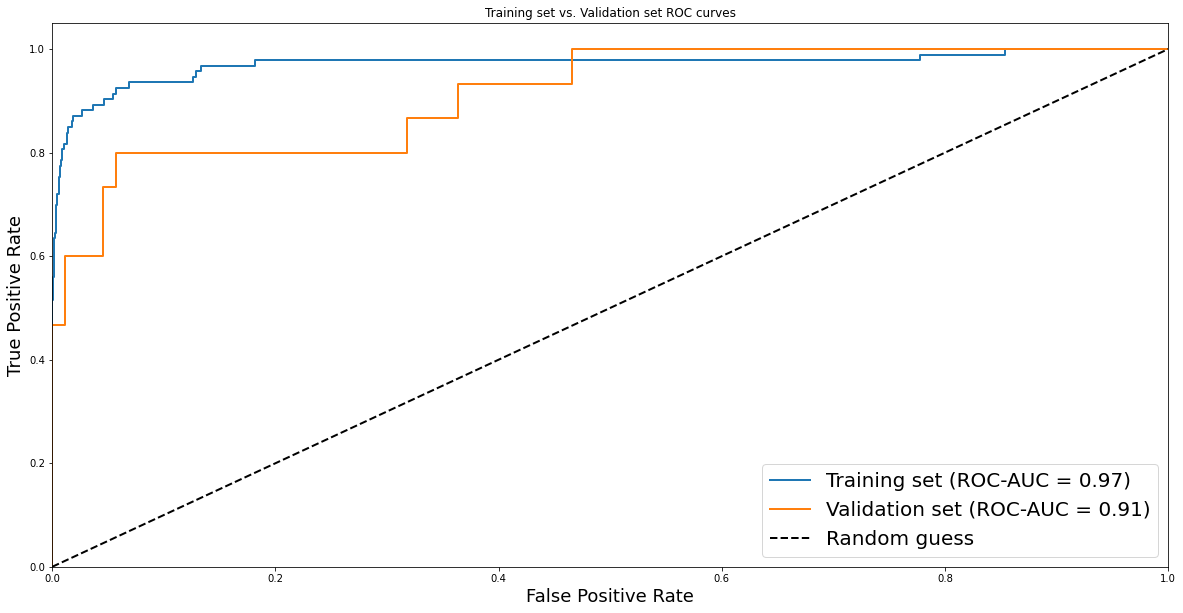

Confusion matrix, without normalization
[[88  0]
 [ 8  7]]


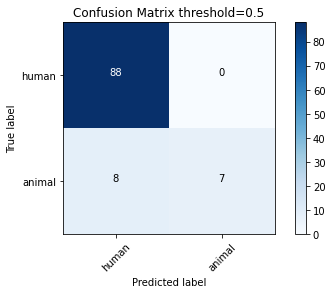

In [63]:
#LSNR
pred_lsnr = [model.predict(train_x_lsnr), model.predict(val_x_lsnr)]
actual_lsnr = [train_y_lsnr, val_y_lsnr]
utils.stats(pred_lsnr, actual_lsnr)

cm = confusion_matrix(y_true=val_y_lsnr, y_pred=( model.predict(val_x_lsnr)>0.5)*1)
cm_plot_labels = ['human','animal']

utils.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f"Confusion Matrix threshold={threshold}")

Altough the scores are very comparable between HSNR and LSNR validation sets, we can see that in the case of LSNR, ther are no missclassifications of himans as animals, while in HSNR the errors are more evenly distributed. it could be a support for the hypothsis that the SNR level contain valueble information for the classification task, but it could also be an artifact that can be explained by the small validation set.<br><br>

next, we'll try adding the SNR type as a variable to the model in the Fully connected stage and see if there's any change. Since we are going to concatenate different inputs, we will use a different model building approach in keras

In [133]:
# define two sets of inputs
inputA = Input(shape = (img_width, img_height, 1))
inputB = Input(shape=(1))
# the first branch operates on the first input
x = Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape)(inputA)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Model(inputs=inputA, outputs=x)

# combine the output of the two branches
combined = concatenate([x.output, inputB])


combined = Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init)(combined)
combined = Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init)(combined)
combined = Dense(1, activation='sigmoid', kernel_initializer = init)(combined)
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, inputB], outputs= combined)

In [134]:
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 126, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 124, 30, 16)  160         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 62, 15, 16)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 60, 13, 32)   4640        max_pooling2d_8[0][0]            
______________________________________________________________________________________

In [135]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 10
optimizer = Adam(learning_rate = 0.001)
#input_shape = (img_width, img_height, 1)

#init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
#model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

In [136]:
train_snr = train_dff[train_dff.is_validation==False].snr_type
train_snr = train_snr.apply(lambda x: 0 if x=="HighSNR" else 1).astype('float')
val_snr = train_dff[train_dff.is_validation].snr_type
val_snr = val_snr.apply(lambda x: 0 if x=="HighSNR" else 1).astype('float')


train_snr.shape

(6568,)

In [137]:
# Model fit


callbacks = []
if WANDB_enable:
  wandb.init(project="mafat",name="first")
  callbacks.append(WandbCallback())

history = model.fit([train_x,train_snr], train_y, batch_size = batch_size, epochs = no_epochs, 
                     callbacks=callbacks,validation_data = ([val_x,val_snr], val_y))

Epoch 1/10
411/411 [==============================] - 19s 47ms/step - loss: 0.5062 - auc_8: 0.9315 - accuracy: 0.9062 - val_loss: 0.5928 - val_auc_8: 0.8159 - val_accuracy: 0.7443
Epoch 2/10
411/411 [==============================] - 18s 43ms/step - loss: 0.2382 - auc_8: 0.9526 - accuracy: 0.9230 - val_loss: 0.5322 - val_auc_8: 0.8780 - val_accuracy: 0.7605
Epoch 3/10
411/411 [==============================] - 16s 38ms/step - loss: 0.2099 - auc_8: 0.9631 - accuracy: 0.9345 - val_loss: 0.4628 - val_auc_8: 0.9029 - val_accuracy: 0.8123
Epoch 4/10
411/411 [==============================] - 16s 39ms/step - loss: 0.1886 - auc_8: 0.9698 - accuracy: 0.9405 - val_loss: 0.5236 - val_auc_8: 0.9027 - val_accuracy: 0.8026
Epoch 5/10
411/411 [==============================] - 17s 40ms/step - loss: 0.1762 - auc_8: 0.9743 - accuracy: 0.9435 - val_loss: 0.4246 - val_auc_8: 0.9086 - val_accuracy: 0.8252
Epoch 6/10
411/411 [==============================] - 16s 40ms/step - loss: 0.1690 - auc_8: 0.9747 -

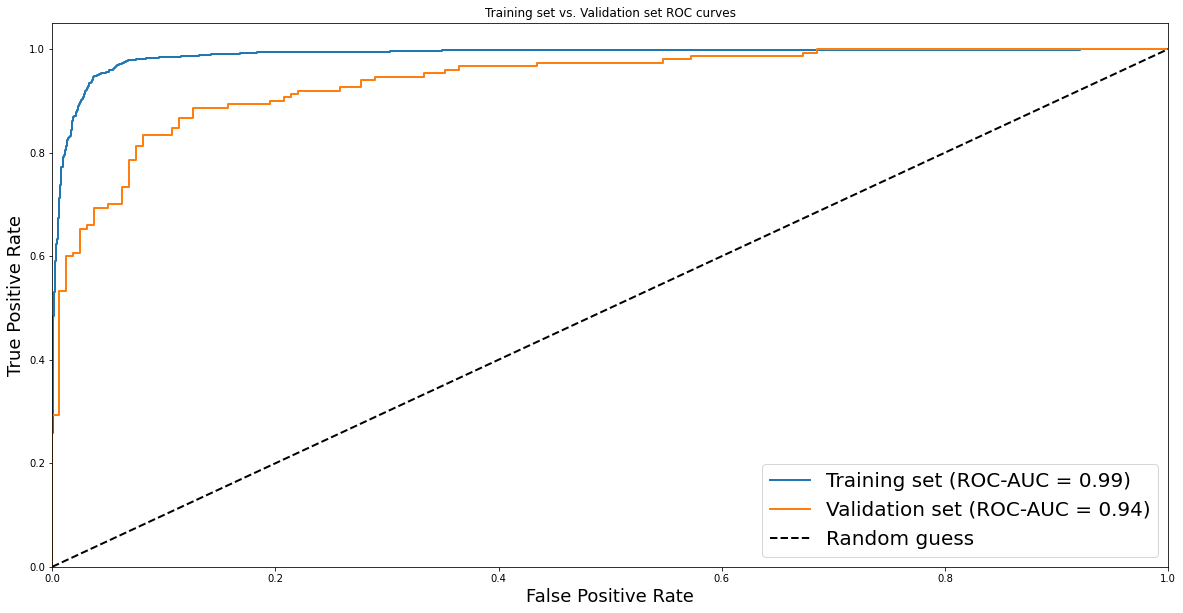

In [138]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict([train_x,train_snr]), model.predict([val_x,val_snr])]
actual = [train_y, val_y]
utils.stats(pred, actual)

Confusion matrix, without normalization
[[142  17]
 [ 25 125]]


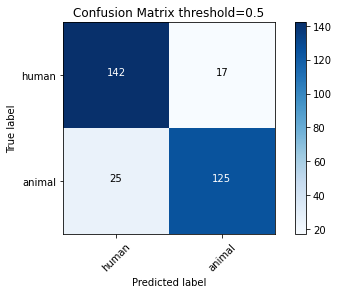

In [139]:
cm = confusion_matrix(y_true=val_y, y_pred=(model.predict([val_x,val_snr])>0.5)*1)
cm_plot_labels = ['human','animal']

utils.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f"Confusion Matrix threshold={threshold}")

# Conclusion
Adding the explisit SNR type information does not improve the preformence of the model by a significant amount (same number of total errors commited, albiet in a different categorical distribution), it is apperant that the SNR is implicitly extracted by the model in the training steps. therefore there isn't much sense in exploring different ways to come up with a finer score for the SNR value.

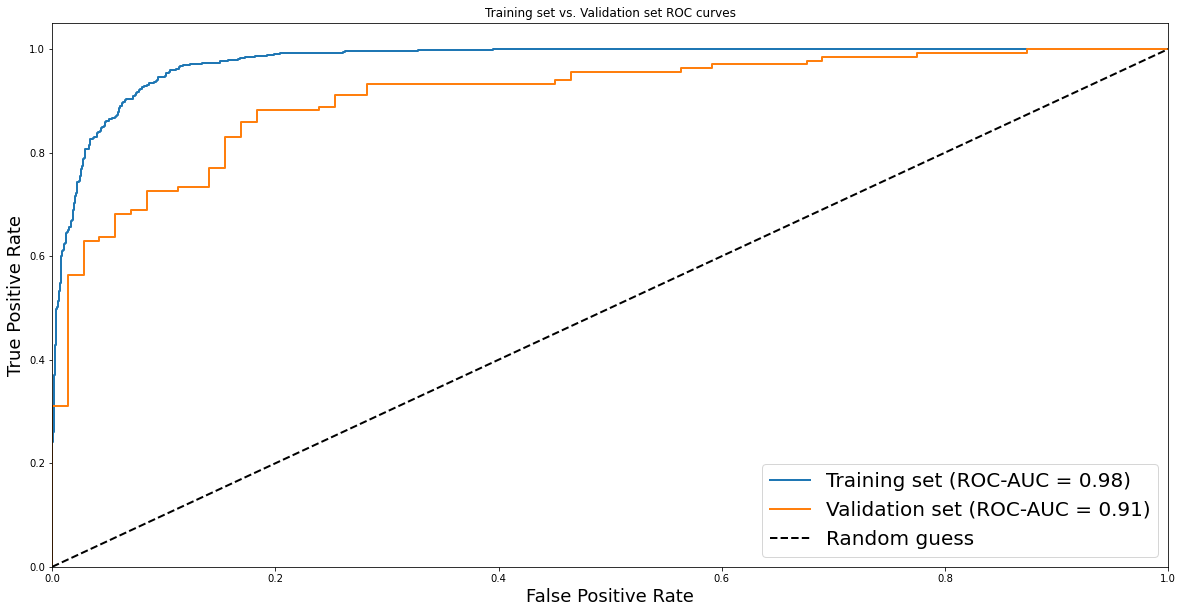

Confusion matrix, without normalization
[[ 54  17]
 [ 16 119]]


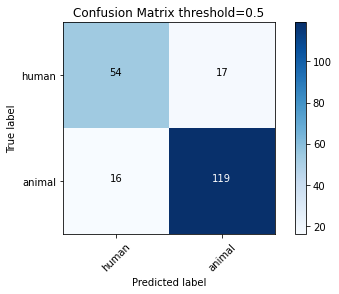

In [149]:
#HSNR
pred_hsnr = [model.predict([train_x_hsnr,np.zeros(len(train_x_hsnr))]), model.predict([val_x_hsnr,np.zeros(len(val_x_hsnr))])]
actual_hsnr = [train_y_hsnr, val_y_hsnr]
utils.stats(pred_hsnr, actual_hsnr)

cm = confusion_matrix(y_true=val_y_hsnr, y_pred=( model.predict([val_x_hsnr,np.zeros(len(val_x_hsnr))])>0.5)*1)
cm_plot_labels = ['human','animal']

utils.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f"Confusion Matrix threshold={threshold}")

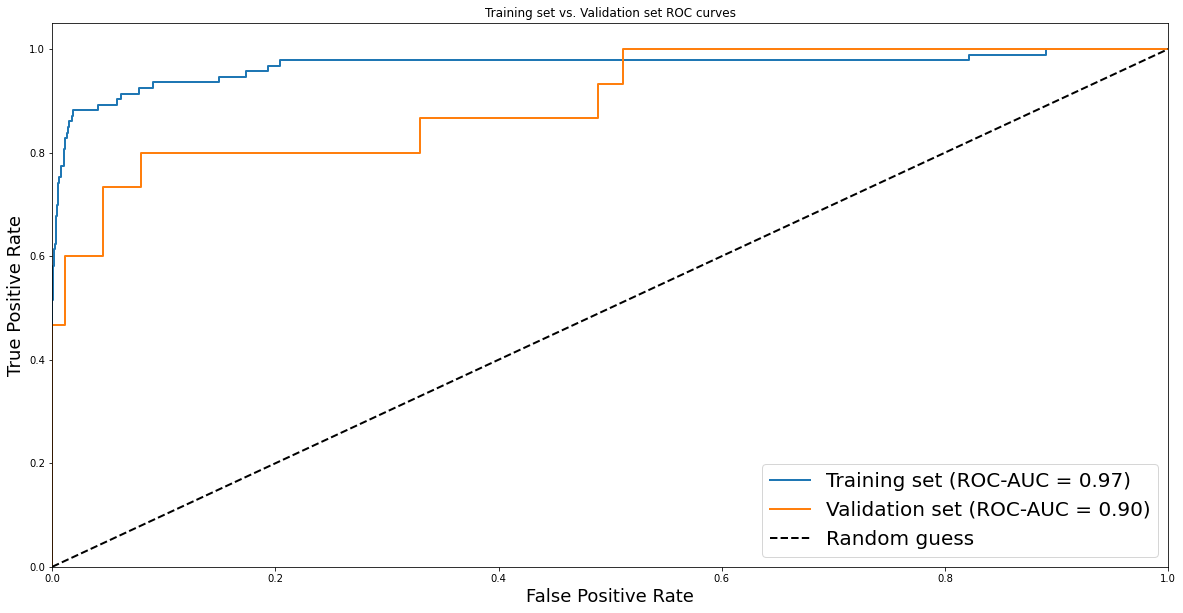

Confusion matrix, without normalization
[[88  0]
 [ 9  6]]


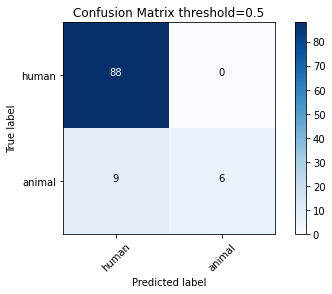

In [150]:
#LSNR

pred_lsnr = [model.predict([train_x_lsnr,np.ones(len(train_x_lsnr))]), model.predict([val_x_lsnr,np.ones(len(val_x_lsnr))])]
actual_lsnr = [train_y_lsnr, val_y_lsnr]
utils.stats(pred_lsnr, actual_lsnr)

cm = confusion_matrix(y_true=val_y_lsnr, y_pred=( model.predict([val_x_lsnr,np.ones(len(val_x_lsnr))])>0.5)*1)
cm_plot_labels = ['human','animal']

utils.plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title=f"Confusion Matrix threshold={threshold}")

